In [1]:
import pandas as pd
import numpy as np

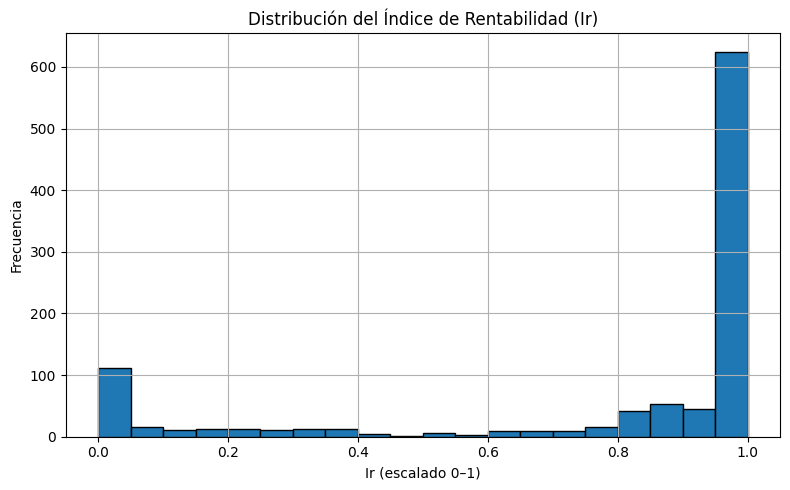

In [2]:
def procesar_y_graficar_Ir(df_train, df_test=None, n_iter=1000, mostrar_grafica=True, drop_first=False):
   import numpy as np
   import pandas as pd
   import matplotlib.pyplot as plt
   from scipy.special import expit
   
   metas = {
       'Base': 480000,
       'Hogar': 490000,
       'Peatonal': 420000,
       'Receso': 516000
   }
   
   def calcular_Po(df, n_iter=1000):
       meses_por_mes = {}
       for m in range(1, 13):
           str_m = str(m).zfill(2)
           key2024 = f"2024{str_m}"
           if key2024 in df.columns and key2024 not in ['202408', '202409', '202410']:
               meses_por_mes[str_m] = [f"2023{str_m}", key2024]
           else:
               meses_por_mes[str_m] = [f"2023{str_m}"]
       
       resultados = []
       for _ in range(n_iter):
           seleccion = [np.random.choice(meses_por_mes[str(m).zfill(2)]) for m in range(1, 13)]
           cumplimiento = []
           for mes in seleccion:
               ventas = df[mes]
               metas_mes = df['ENTORNO_DES'].map(metas)
               puntaje = (ventas >= 1.3 * metas_mes).astype(int)
               cumplimiento.append(puntaje)
           total_cumplido = np.sum(cumplimiento, axis=0)
           Po = np.select(
               [total_cumplido < 7, total_cumplido == 7, total_cumplido == 8,
                total_cumplido == 9, total_cumplido == 10, total_cumplido == 11,
                total_cumplido == 12],
               [0, 0.1, 0.2, 0.4, 0.6, 0.8, 1], default=0
           )
           resultados.append(Po)
       return np.mean(resultados, axis=0)
   
   def calcular_Gn(df):
       meses_2024 = [f"2024{str(m).zfill(2)}" for m in range(1, 13) if f"2024{str(m).zfill(2)}" not in ['202408', '202409', '202410']]
       ventas_2024 = df[meses_2024].sum(axis=1)
       metas_totales = df['ENTORNO_DES'].map(metas) * 9 * 1.5
       return ventas_2024 - metas_totales
   
   # Procesar ambos datasets
   df_train = df_train.copy()
   if df_test is not None:
       df_test = df_test.copy()
       df_combined = pd.concat([df_train, df_test], keys=['train', 'test'])
   else:
       df_combined = df_train.copy()
   
   # Calcular Ir para el dataset combinado
   Po = calcular_Po(df_combined, n_iter)
   Gn = calcular_Gn(df_combined)
   Ir = Po + expit(Gn)
   Ir_escalado = (Ir - np.min(Ir)) / (np.max(Ir) - np.min(Ir))
   df_combined['Ir'] = Ir_escalado
   
   # Graficar distribución
   if mostrar_grafica:
       plt.figure(figsize=(8, 5))
       plt.hist(Ir_escalado, bins=20, edgecolor='black')
       plt.title('Distribución del Índice de Rentabilidad (Ir)')
       plt.xlabel('Ir (escalado 0–1)')
       plt.ylabel('Frecuencia')
       plt.grid(True)
       plt.tight_layout()
       plt.show()
   
   # Eliminar columnas mensuales
   columnas_ventas = [col for col in df_combined.columns if col.isdigit() and len(col) == 6]
   df_combined = df_combined.drop(columns=columnas_ventas)
   
   # Codificación de variables categóricas
   columnas_cat = df_combined.select_dtypes(include='object').columns.tolist()
   if 'PLAZA_CVE' in df_combined.columns:
       columnas_cat.append('PLAZA_CVE')
   columnas_cat = list(dict.fromkeys(columnas_cat))
   columnas_cat = [col for col in columnas_cat if 'id' not in col.lower() or col == 'LID_UBICACION_TIENDA']
   df_combined = pd.get_dummies(df_combined, columns=columnas_cat, drop_first=drop_first)
   
   # Eliminar columnas auxiliares
   if 'Total general' in df_combined.columns:
       df_combined = df_combined.drop(columns=['Total general'])
   if 'TIENDA_ID' in df_combined.columns:
       df_combined = df_combined.drop(columns=['TIENDA_ID'])
   
   # Separar datasets
   if df_test is not None:
       df_train_final = df_combined.loc['train'].reset_index(drop=True)
       df_test_final = df_combined.loc['test'].reset_index(drop=True)
       return df_train_final, df_test_final
   else:
       return df_combined

df_train = pd.read_csv('Train1.csv')
df_test = pd.read_csv('Test1.csv')
df_train_ir, df_test_ir = procesar_y_graficar_Ir(df_train, df_test=df_test, n_iter=1000)

In [3]:
df_train_ir.to_csv('Train2.csv', index=False)
df_test_ir.to_csv('Test2.csv', index=False)

Si la tienda tiene menos de 7 se considera 0 objetivo no cumplido.
Si 7 0.1, Si 8 entonces 0.2, si 9 0.4, si 10 0.6, si 11 0.8 y si 12 1.

# 2

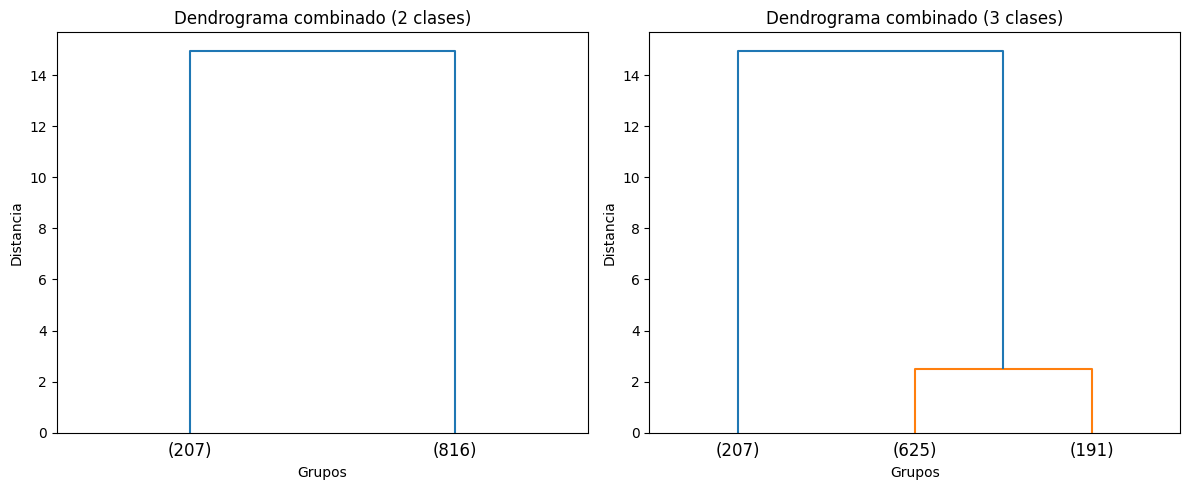

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# 1. Cargar archivos
ruta_train = "Train2.csv"
ruta_test = "Test2.csv"

df_train = pd.read_csv(ruta_train)
df_test = pd.read_csv(ruta_test)

# 2. Unir conjuntos usando 'Ir'
df_all = pd.concat([
    df_train[['ID', 'Ir']],
    df_test[['ID', 'Ir']]
], ignore_index=True)

# 3. Clustering jerárquico con método Ward
X = df_all['Ir'].values.reshape(-1, 1)
Z = linkage(X, method='ward')

# 4. Dendrogramas para 2 y 3 clases
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
dendrogram(Z, truncate_mode='lastp', p=2)
plt.title('Dendrograma combinado (2 clases)')
plt.xlabel('Grupos')
plt.ylabel('Distancia')

plt.subplot(1, 2, 2)
dendrogram(Z, truncate_mode='lastp', p=3)
plt.title('Dendrograma combinado (3 clases)')
plt.xlabel('Grupos')
plt.ylabel('Distancia')

plt.tight_layout()
plt.show()

# 5. Clasificación en 2 clases
clases = fcluster(Z, t=2, criterion='maxclust') - 1
df_all['__clase_temp__'] = clases

# 6. Determinar cuál es la clase mayoritaria
clase_mayoritaria = df_all['__clase_temp__'].value_counts().idxmax()

# 7. Asignar etiquetas nominales
df_all['Retble'] = np.where(
    df_all['__clase_temp__'] == clase_mayoritaria,
    'Rentable',
    'No rentable'
)

# 8. Eliminar variable auxiliar
df_all = df_all.drop(columns='__clase_temp__')

# 9. Separar nuevamente Train y Test
df_train_final = df_train.merge(df_all[['ID', 'Retble']], on='ID', how='left')
df_test_final = df_test.merge(df_all[['ID', 'Retble']], on='ID', how='left')

from sklearn.metrics.pairwise import euclidean_distances

def calcular_distancias_cercanas(df, n_vecinos=5):
   coords = df[['lat', 'lon']].values
   distancias = euclidean_distances(coords)
   
   for i in range(len(df)):
       distancias_fila = distancias[i]
       indices_cercanos = np.argsort(distancias_fila)[1:n_vecinos+1]
       
       for j, idx in enumerate(indices_cercanos):
           df.loc[i, f'dist_{j+1}'] = distancias_fila[idx]
   
   return df

# Calcular distancia al vecino más cercano para Train
df_train_final['dist_vecino'] = calcular_distancias_cercanas(
  df_train_final.rename(columns={'LATITUD_NUM': 'lat', 'LONGITUD_NUM': 'lon'}),
  n_vecinos=1
)['dist_1']

# Calcular distancia al vecino más cercano para Test
df_test_final['dist_vecino'] = calcular_distancias_cercanas(
  df_test_final.rename(columns={'LATITUD_NUM': 'lat', 'LONGITUD_NUM': 'lon'}),
  n_vecinos=1
)['dist_1']

df_train_final = df_train_final.drop(columns=['Ir'])
df_test_final = df_test_final.drop(columns=['Ir'])

# Guardar archivos actualizados
df_train_final.to_csv("Train_Final.csv", index=False)
df_test_final.to_csv("Test_Final.csv", index=False)
